In [1]:
%load_ext autoreload

In [2]:
import sys
import os
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES']='2'
pd.set_option('display.max_colwidth', None)
sys.path.append('/workspace/computationally-undermining-arguments/scripts/')
sys.path.append('/workspace/computationally-undermining-arguments/src-py')
sys.path.append('/workspace/computationally-undermining-arguments/thirdparty/transfer-learning-conv-ai/')

In [119]:
%autoreload
import ast
import re
import interact
import evaluation
import json
import torch
import numpy as np
from argparse import Namespace
from tabulate import tabulate

In [132]:
%autoreload
import utility
import evaluation
import interact

In [5]:
RANDOM_SEED = 42

In [6]:
#df = pd.DataFrame(json_preds)

In [7]:
def load_hua_preds(path):
    with open(path, 'r') as f:
        json_preds =[]
        for line in f:
            row = json.loads(line)
            row['pred_str'] = ' '.join(row['pred'])
            json_preds.append(row)
    
    df = pd.DataFrame(json_preds)
    df.set_index('tid',inplace=True)
    return df

def load_hua_data(data_path1, data_path2):
    
    with open(data_path1, 'r', encoding='utf-8') as f:
        argument=ast.literal_eval(f.read())
    
    df = pd.DataFrame(argument)
    df.set_index('name',inplace=True)
    df.columns = ['claim','post','counter pretext']
    df['claim'] = df['claim'].apply(lambda x: re.sub('(cmv)[\.-:,]?', '', x[0].lower()).replace(':', ''))
    df['claim'] = df['claim'].apply(lambda x: x + "." if x.strip()[-1] != "." else x)
    df['post_length'] = df['post'].apply(lambda x : len(x))
    
    hua_input_=[]
    with open(data_path2, "r", encoding='utf-8') as f:
        ln= f.readline()
        while(ln):
            hua_input_.append(ast.literal_eval(ln))
            ln=f.readline()
    
    input_with_counter = []
    for post in hua_input_:
        counterarg_list = []
        counter_args = post['target_counterarg_list']
        for i, counter_arg in enumerate(counter_args):
            counterarg_list.append(" ".join([" ".join(sent['tokens']) for sent in counter_arg['target_counterarg']]))
        input_with_counter.append({'id' : post['id'],
                                  'counter_args' : counterarg_list})
    
    hua_counter = pd.DataFrame(input_with_counter)
    hua_counter.set_index('id',inplace=True)
    
    df = pd.merge(hua_counter, df,left_index =True, right_index=True, how='inner')

    return df

def convert_to_json(df, claim_clm, post_clm):
    ranking_problems = []
    for idx, row in df.iterrows():
            documents = []
            for sent_idx, sent in enumerate(row[post_clm]):
                documents.append({"relevance": -1, 
                 "docText": sent})
            
            ranking_problems.append({
                "queryText": row[claim_clm],
                "documents": documents
            })
    
    return {
        "rankingProblems": ranking_problems
    }

### To reproduce Hua and Wang results:

Training:

In [8]:
! python /workspace/computationally-undermining-arguments/thirdparty/textgen-emnlp19/src/main.py --mode=train \
    --exp_name=arggen_exp \
    --encode_passage \
    --type_conditional_lm \
    --task=arggen \
    --batch_size=2 \
    --num_train_epochs=30 \
    --logging_freq=2
    --max_src_words=500 \
    --max_passage_words=400 \
    --max_sent_num=10 \
    --max_bank_size=70 \

Prediction:

In [9]:
! CUDA_VISIBLE_DEVICES=4 python /workspace/computationally-undermining-arguments/thirdparty/textgen-emnlp19/src/main.py --mode=predict \
    --exp_name=arggen_exp \
    --encode_passage \
    --type_conditional_lm \
    --task=arggen \
    --batch_size=8 \
    --load_model_path=epoch_27_train_192.9461_val_183.0755_ppl_5.6036.tar

### Predicting weak premises:

In [9]:
hua_df = load_hua_data('/workspace/ceph_data/argument-undermining/data/undermine_arguments_eval_hua.json',
                          '/workspace/ceph_data/argument-undermining/data/test.eval.jsonl')

In [10]:
hua_and_wang_data = convert_to_json(hua_df, 'claim', 'post')
json.dump(hua_and_wang_data, open('/workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking.json', 'w'))

In [ ]:
#predict premises scores:
#1. run the server
#2. do the predictions
export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/jo_vul_detection_listwise_tmp/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=2 tensorflow_model_server \
  --port=8503 \
  --rest_api_port=8501 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

In [7]:
#I had to run it from the console :(
! python /workspace/computationally-undermining-arguments/thirdparty/ranking/tensorflow_ranking/extension/examples/tfrbert_client_predict_from_json.py \
    --vocab_file=/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt \
    --sequence_length=128 \
    --input_file=/workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking.json \
    --output_file=/workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking_preds.json \
    --do_lower_case

2020-11-22 14:15:20.458246: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
 * Running with arguments: Namespace(do_lower_case=True, input_file='/workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking.json', output_file='/workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking_preds.json', sequence_length=128, server_port='8503', vocab_file='/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt')
 * Generating predictions for JSON ranking problems (filename: /workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking.json)

Predicting 1 / 1612 (0.06%)
Predicting 2 / 1612 (0.12%)
Predicting 3 / 1612 (0.19%)
Predicting 4 / 1612 (0.25%)
Predicting 5 / 1612 (0.31%)
Predicting 6 / 1612 (0.37%)
Predicting 7 / 1612 (0.43%)
Predicting 8 / 1612 (0.50%)
Predicting 9 / 1612 (0.56%)
Predicting 10 / 1612 (0.62%)
Predicting 11 / 1612 (0.68%)
Pre

In [11]:
hua_preds_df = load_hua_preds('/workspace/ceph_data/argument-undermining/data/hua_and_wang_preds.jsonlist')

### Loading data with weak premises:

In [61]:
#hua_df = pd.read_json('/workspace/ceph_data/argument-undermining/data/hua_and_wang_test_ds.json')

In [12]:
hua_and_wang_data = json.load(open('/workspace/ceph_data/argument-undermining/data/hua_and_wang_for_ranking_preds.json'))

In [13]:
hua_df['row_id'] = [x for x in range(len(hua_df))]
hua_df['weak_premise'] = hua_df.apply(lambda row: [sorted(hua_and_wang_data['rankingProblemsOutput'][row['row_id']]['documents'],
                                                        key=lambda x: -x['score'])[0]['docText']], axis=1)

hua_df['3_weak_premises'] = hua_df.apply(lambda row: [x['docText'] for x in sorted(hua_and_wang_data['rankingProblemsOutput'][row['row_id']]['documents'],
                                                        key=lambda x: -x['score'])[0:3]], axis=1)
#hua_df['3_weak_premises'] = hua_df['3_weak_premises'].apply(lambda x: ' '.join(x))

np.random.seed(RANDOM_SEED)
hua_df['rand_premises'] = hua_df.apply(lambda row: list(np.random.choice(row['post'], 3, replace=True)), axis=1)

### Perform Attacks:

In [14]:
args = Namespace(max_length=150, device='cuda:0', temperature=1.0, 
                 top_k=50, top_p=0.95, no_sample=False, min_length=100, premise_extra=False,
)

baseline_path = '/workspace/ceph_data/argument-undermining/models/gen_models/Dec10_21-48-03_gammaweb03_jo_baseline_gpt/'
app_v2_path = '/workspace/ceph_data/argument-undermining/models/gen_models/Dec10_21-50-50_gammaweb03_my_approach_v2/'
app_v3_path = '/workspace/ceph_data/argument-undermining/models/gen_models/Dec10_21-53-13_gammaweb03_my_approach_v3/'
app_v4_path = '/workspace/ceph_data/argument-undermining/models/gen_models/Dec21_17-10-34_gammaweb03_my_approach_v4/'

In [15]:
# hua_df_sample = hua_df.sample(1000)
# hua_df_sample.to_pickle('hua_df_sample.pkl')

In [16]:
hua_df_sample = pd.read_pickle('hua_df_sample.pkl')
final_df = pd.read_pickle('./sample_pred_on_hua_data.pkl')

In [21]:
hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, baseline_path, args, 'baseline_final', 'title+full_post', '', baseline=True)

args.build_instance_version = 'v2'
hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v2_path, args, 'app_v2_attack_on_weak_premise', 'title+full_post', 'weak_premise', baseline=False)
hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v2_path, args, 'app_v2_attack_on_3_weak_premises', 'title+full_post', '3_weak_premises', baseline=False)

args.build_instance_version = 'v3'
hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v3_path, args, 'app_v3_attack_on_weak_premise', 'title+full_post', 'weak_premise', baseline=False)
hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v3_path, args, 'app_v3_attack_on_3_weak_premises', 'title+full_post', '3_weak_premises', baseline=False)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of the model checkpoint at /workspace/ceph_data/argument-undermining/models/gen_models/Dec21_17-10-34_gammaweb03_my_approach_v4/ were not used when initializing OpenAIGPTLMHeadModel: ['multiple_choice_head.summary.weight', 'multiple_choice_head.summary.bias', 'transformer.position_ids']
- This IS expected if you are initializing OpenAIGPTLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing OpenAIGPTLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/workspace/computationally-undermining-arguments/thirdparty/transfer-learning-conv-ai/interact.py:145: UserWarning: Warning: model generating 

In [100]:
#Testing different length:
#args.build_instance_version = 'v3'
#args.min_length=50
#args.max_length=100
#hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v3_path, args, 'app_v3_attack_on_3_weak_premises_max_len_100', 'title+full_post', '3_weak_premises', baseline=False)

Perform attacks on the top 3 weak premises individually:

In [34]:
args.build_instance_version = 'v2'
for i in range(0,3):
    hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v2_path, args, 'app_v2_attack_on_weak_premise_{}'.format(i), 'title+full_post', '3_weak_premises', weak_premise_idx=i, baseline=False)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of the model checkpoint at /workspace/ceph_data/argument-undermining/models/gen_models/Dec10_21-50-50_gammaweb03_my_approach_v2/ were not used when initializing OpenAIGPTLMHeadModel: ['multiple_choice_head.summary.weight', 'multiple_choice_head.summary.bias', 'transformer.position_ids']
- This IS expected if you are initializing OpenAIGPTLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing OpenAIGPTLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/workspace/computationally-undermining-arguments/thirdparty/transfer-learning-conv-ai/interact.py:145: UserWarning: Warning: model generating 

In [37]:
args.build_instance_version = 'v3'
for i in range(0,3):
    hua_df_sample = utility.perform_attacks_hua_df(hua_df_sample, app_v3_path, args, 'app_v3_attack_on_weak_premise_{}'.format(i), 'title+full_post', '3_weak_premises', weak_premise_idx=i, baseline=False)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of the model checkpoint at /workspace/ceph_data/argument-undermining/models/gen_models/Dec10_21-53-13_gammaweb03_my_approach_v3/ were not used when initializing OpenAIGPTLMHeadModel: ['multiple_choice_head.summary.weight', 'multiple_choice_head.summary.bias', 'transformer.position_ids']
- This IS expected if you are initializing OpenAIGPTLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing OpenAIGPTLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of the model checkpoint at /workspace/ceph_data

In [90]:
hua_df_sample.columns

Index(['counter_args', 'claim', 'post', 'counter pretext', 'post_length',
       'row_id', 'weak_premise', '3_weak_premises', 'rand_premises',
       'baseline_final', 'app_v2_attack_on_weak_premise',
       'app_v2_attack_on_3_weak_premises', 'app_v3_attack_on_weak_premise',
       'app_v3_attack_on_3_weak_premises', 'app_v4_attack_on_weak_premise',
       'app_v4_attack_on_3_weak_premises', 'app_v2_attack_on_weak_premise_0',
       'app_v2_attack_on_weak_premise_1', 'app_v2_attack_on_weak_premise_2',
       'app_v3_attack_on_weak_premise_', 'app_v3_attack_on_weak_premise_0',
       'app_v3_attack_on_weak_premise_1', 'app_v3_attack_on_weak_premise_2',
       'app_v2_best_attack', 'app_v3_best_attack',
       'app_v3_attack_on_3_weak_premises_max_len_100'],
      dtype='object')

In [91]:
def best_pred(row, app_name):
    overlap_percentages = []
    for clm in ['{}_{}'.format(app_name, i) for i in range(0,3)]:
        overlap_percentages.append(utility.overlap_between_attack_and_attacked_premises([row['3_weak_premises'][i]], row[clm]))

    #print('{}_{}'.format(app_name, overlap_percentages.index(max(overlap_percentages))))
    return row['{}_{}'.format(app_name, overlap_percentages.index(max(overlap_percentages)))]

In [66]:
hua_df_sample['app_v2_best_attack'] = hua_df_sample.apply(lambda row: best_pred(row, 'app_v2_attack_on_weak_premise'), axis=1)
hua_df_sample['app_v3_best_attack'] = hua_df_sample.apply(lambda row: best_pred(row, 'app_v3_attack_on_weak_premise'), axis=1)

In [92]:
#Joining our predictions with hua and wang's preds
final_df = hua_df_sample.join(hua_preds_df)

In [93]:
len(final_df)

1000

### Evaluate:

In [69]:
final_df[['claim', 'post', '3_weak_premises', 'app_v3_best_attack']].head(n=20)

,claim,post,3_weak_premises,app_v3_best_attack
9qi7ju,extremism is the logical conclusion of any social movement .,"[to start with , movements -- like veganism , feminism , religion , cancer research , the kkk , civil rights , and many more -- are organizations that supply two "" products "" to the public : outrage and change ., organizations that do n't supply enough outrage , like the kkk , inevitably flounder , and organizations that do n't supply enough change , like kony 2012 , may have a burst of success but then vanish ., then , at some point down the road of a movement 's lifetime , the actual goals of the movement change ., while the stated goals of the movement have n't changed , the actual driving force of the movement has shifted : now the organization only seeks to preserve its own existence ., and for a while , nothing changes , since there 's still activism to accomplish ., but what happens when a movement "" wins "" ?, when everything the movement stands for is achieved ?, the organization is still pursuing its continued existence , but outrage in its field has dried up ., so what is the organization to do ?, it ca n't just dissolve , that 's directly against its raison d'etre ., but its outrage reserves are dry ., thus , it begins manufacturing outrage ., this is how we get oppression olympics , this is how we get conservative christians who literally believed obama would take away their guns , this is how we get susan komen suing other cancer research firms : the movement ran out of real outrage and had to resort to manufacturing their own ., no movement woke up and decided to become extremists ( well , some did , but not the majority ) ., instead , these movements started casting their nets further afield for outrage and change , and all they reeled in was crazy ., and since the crazy was producing more outrage and change than the more levelheaded members , they move up into more control of the movement , until the entire movement is run by crazy .]","[this is how we get oppression olympics , this is how we get conservative christians who literally believed obama would take away their guns , this is how we get susan komen suing other cancer research firms : the movement ran out of real outrage and had to resort to manufacturing their own ., but what happens when a movement "" wins "" ?, when everything the movement stands for is achieved ?]","i think a lot of people are unaware that its a'single'organization with a single'goal '. this makes the ideology more real to the individuals who have to create the ideology to the ideology. it is also worth noting that the'movement'isn't a movement, but rather a group of people attempting to make money. do you think that it's okay for a group of people to be extremists, but also for them to use what they have to their advantage?"
9xas9t,"we should follow the nordic model when it comes to prostitution , that is it is illegal to buy sex but not to sell it .","[when caught its unfair someone who had no choice in the matter is arrested ., there 's so many stories of men ( and some women ) knowing rightly that the prostitute was underage or unwilling but they still follow through with it ., those people in my opinion are just as much a rapist as those who drag strangers in a dark alley , and they should be arrested ., people may say that prostitution is the only answer for some people , but at the end of the day if a man or a woman is starving you have to feed them , not exploit them ., people also say its just like any other job , but is there a high risk of pregnancy , ptsd , rape and violence , stds , drug addiction and more with working at mcdonalds ??, legalising prostitution may not work either , as there are stories of rapists who got let off by telling the jury their victim was a prostitute ., it would also mean a pimp would n't get in trouble for their exploitation ., one time i was talking to my cousin who said there 's nothing wrong with buying a prostitute ., i 

In [94]:
final_df.to_pickle('./sample_pred_on_hua_data.pkl')

In [71]:
final_df[['claim', '3_weak_premises', 'app_v2_attack_on_3_weak_premises', 'app_v3_attack_on_3_weak_premises', 'app_v2_best_attack', 'app_v3_best_attack' , 'pred_str']].to_csv('./hua_wang_preds.csv')

In [96]:
final_df_sample = final_df #final_df.sample(100)

In [144]:
def print_scores(final_df_sample, gt_clm, max_refs=None, best_match=False):
    refs = [np.random.choice(x, max_refs) if max_refs != None and len(x) > max_refs else x for x in final_df_sample[gt_clm].tolist()]
    
    app_v2_weak_premise_score, app_v2_weak_premise_scores  = evaluation.eval_model(refs, final_df_sample.app_v2_attack_on_weak_premise.tolist(), best_match=best_match)
    app_v2_3_weak_premises_score, app_v2_3_weak_premises_scores  = evaluation.eval_model(refs, final_df_sample.app_v2_attack_on_3_weak_premises.tolist(), best_match=best_match)
    app_v2_best_score, app_v2_best_scores  = evaluation.eval_model(refs, final_df_sample.app_v2_best_attack.tolist(), best_match=best_match)

    app_v3_weak_premise_score, app_v3_weak_premise_scores  = evaluation.eval_model(refs, final_df_sample.app_v3_attack_on_weak_premise.tolist(), best_match=best_match)
    app_v3_3_weak_premises_score, app_v3_3_weak_premises_scores  = evaluation.eval_model(refs, final_df_sample.app_v3_attack_on_3_weak_premises.tolist(), best_match=best_match)
    app_v3_best_score, app_v3_best_scores  = evaluation.eval_model(refs, final_df_sample.app_v3_best_attack.tolist(), best_match=best_match)

    baseline_score, baseline_scores = evaluation.eval_model(refs, final_df_sample.baseline_final.tolist(), best_match=best_match)
    hua_score, hua_scores = evaluation.eval_model(refs, final_df_sample.pred_str.tolist(), best_match=best_match)

    print(tabulate([['baseline', ''] + baseline_score,
                #['2. App', 'random'] + app_v2_score,
                ['2. App', '1 weak premise'] + app_v2_weak_premise_score,
                ['2. App', '3 weak premises'] + app_v2_3_weak_premises_score, 
                ['2. App', 'best of 3 weak premises'] + app_v2_best_score, 
                #['3. App', 'random'] + app_v3_score,
                ['3. App', '1 weak premise'] + app_v3_weak_premise_score,
                ['3. App', '3 weak premises'] + app_v3_3_weak_premises_score,
                ['3. App', 'best of 3 weak premises'] + app_v3_best_score, 
                ['Hua&Wang', ''] + hua_score], 
               headers=['App', 'attacked', 'meteor', 'bleu-1', 'bleu-1&2']))
    
    print('-------------')
    print(perform_significance_tests(baseline_scores, app_v2_best_scores))
    print(perform_significance_tests(baseline_scores, app_v3_best_scores))

In [134]:
%autoreload
import evaluation

In [130]:
print_scores(final_df_sample, 'counter_args', max_refs=None, best_match=False)

App       attacked                   meteor    bleu-1    bleu-1&2
--------  -----------------------  --------  --------  ----------
baseline                              0.205    53.723      23.874
2. App    1 weak premise              0.207    53.69       23.906
2. App    3 weak premises             0.209    53.856      24.126
2. App    best of 3 weak premises     0.21     54.701      24.393
3. App    1 weak premise              0.209    54.008      24.113
3. App    3 weak premises             0.209    54.384      24.173
3. App    best of 3 weak premises     0.208    55.073      24.706
Hua&Wang                              0.258    64.239      40.21


In [146]:
print_scores(final_df_sample, 'counter_args', max_refs=None, best_match=True)

App       attacked                   meteor    bleu-1    bleu-1&2
--------  -----------------------  --------  --------  ----------
baseline                              0.205    22.741       7.792
2. App    1 weak premise              0.207    22.841       7.839
2. App    3 weak premises             0.209    23.067       7.943
2. App    best of 3 weak premises     0.21     23.4         8.025
3. App    1 weak premise              0.209    23.165       7.946
3. App    3 weak premises             0.209    23.15        7.879
3. App    best of 3 weak premises     0.208    23.251       8.02
Hua&Wang                              0.258    30.16       13.366
-------------
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': False, '%10': True}, 'meteor': {'@5%': True, '%10': True}}
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': False, '%10': True}, 'meteor': {'@5%': True, '%10': True}}


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


#### Save a sample for evaluation:

In [203]:
import nltk
import matplotlib.pyplot as plt

In [213]:
final_df_sample['post_len'] = final_df_sample.post.map(lambda x: len(nltk.word_tokenize(' '.join(x))))
final_df_sample['title_len'] = final_df_sample.claim.map(lambda x: len(nltk.word_tokenize(x)))

In [214]:
np.mean(final_df_sample['title_len'])

26.992

In [208]:
np.mean(final_df_sample['post_len'])

337.765

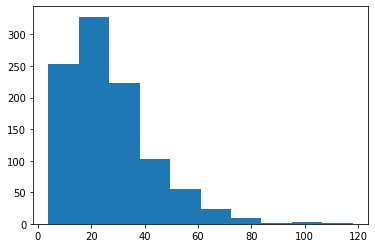

In [215]:
plt.hist(final_df_sample['title_len'])
plt.show()

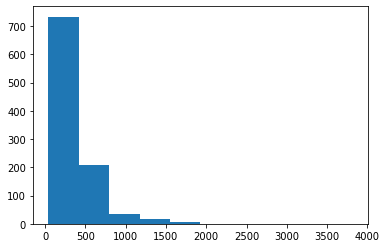

In [209]:
plt.hist(final_df_sample['post_len'])
plt.show()

In [244]:
final_df_sample[final_df_sample.index=='92151y'][['app_v2_attack_on_weak_premise_0', 'app_v2_attack_on_weak_premise_1', 'app_v2_attack_on_weak_premise_2']].head()

,app_v2_attack_on_weak_premise_0,app_v2_attack_on_weak_premise_1,app_v2_attack_on_weak_premise_2
92151y,"there are no such things as monarchs. you are not equal in the grand scheme of things, and so the entire concept of monarchs comes down to what you're allowed to get out of a bunch of crap you'll get out of doing nothing, to which you don't get much out of it. so the answer is that you aren't equal in the grand scheme of things. that's why i'd be curious to see some examples. also, there are plenty of rich people with great wealth.","income inequality is precisely because of the fact that rich people have a vested interest in having a bunch of money in the first place, which leads to great wealth inequality. if you are poor but poor you have no incentive to live. by providing good quality goods and services, you are able to contribute to society better than most poor people. you're basically doing something that is expected of you, which is a wonderful trait. i think the problem is that you should at least be able to be generous towards someone without expecting to be rewarded.",this is a fair point. but that doesn't mean that income inequality isn't a problem. you're looking at it from the perspective of a capitalist. a capitalist. an investor in a business. b the socialist. a developer in a country with a strong business.


In [217]:
sample = final_df_sample[(final_df_sample.post_len <=300) & (final_df_sample.title_len <= 20)][['claim', 'post', 'counter pretext', '3_weak_premises', 'app_v2_best_attack', 'baseline_final' , 'pred_str']].sample(100)

In [219]:
sample.columns = ['claim', 'post', 'comment', '3_weak_premises', 'our_approach', 'baseline' , 'hua_and_wang']

In [223]:
sample['post'] = sample.post.apply(lambda p: ' '.join(p))

In [224]:
sample.to_csv('./data_files/predictions/hua_wang_data/hua_and_wang_ds_predictions.csv')

In [240]:
sample[sample.index=='92151y'].head()

,claim,post,comment,3_weak_premises,our_approach,baseline,hua_and_wang
92151y,there ’s nothing wrong with income inequality .,"billionaires like the rockefellers and trump worked hard to earn their money and provide their families with luxury . meanwhile , my grandpa did n’t and because of that i am of lower-middle class status . just because i ’m poorer does n’t mean i ’m entitled to the cash that the rich spent years to accumulate . i simply have to swallow my pride and start at the bottom . to try and stump income inequality is to meddle with the very basis of pure , unadulterated capitalism and meritocracy . change my view .",,"[to try and stump income inequality is to meddle with the very basis of pure , unadulterated capitalism and meritocracy ., just because i ’m poorer does n’t mean i ’m entitled to the cash that the rich spent years to accumulate ., billionaires like the rockefellers and trump worked hard to earn their money and provide their families with luxury .]","income inequality is precisely because of the fact that rich people have a vested interest in having a bunch of money in the first place, which leads to great wealth inequality. if you are poor but poor you have no incentive to live. by providing good quality goods and services, you are able to contribute to society better than most poor people. you're basically doing something that is expected of you, which is a wonderful trait. i think the problem is that you should at least be able to be generous towards someone without expecting to be rewarded.",it sounds like you have a complex issue here. please expand on what you mean here. how so? i can think of a lot of things that i would rather not mention in that sentence. how about social security. how does it make me entitled to live comfortably without having to worry about people getting hurt?,"this is a great example of how hard it is to invest in low income housing . it 's not like it 's going to end up being worse for everyone . if you do n't like it , you 're going to have to worry about it . the rich do n't want to pay for it because they do n't have to pay taxes . they are n't going to be able to do anything about it , they just do n't want"


In [227]:
def write_to_a_form(df, output_path):
    import csv
    with open(output_path, 'w') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        for row_idx, row in df.iterrows():
            writer.writerow(['Example-{}'.format(row_idx), ''])
            writer.writerow([row['claim'], row['post']])
            writer.writerow(['Counter-1:', row['our_approach']])
            writer.writerow(['Counter-2:', row['hua_and_wang']])

In [228]:
write_to_a_form(sample, './data_files/predictions/hua_wang_data/hua_and_wang_ds_predictions_for_forms.csv')

In [221]:
def prepare_for_vis(df, models_names, output_path):
    
    def annotate_premise(p, weak_premises):
        for x in weak_premises:
            if x in p or p in x:
                return '<weak> ' + p
        return p
    
    #documents
    documents = [{'claim': row['claim'],
                  'weak_premise': row['3_weak_premises'],
                  'premises': row['post'] } for idx, row in df.iterrows()]
    
    with open(output_path+'documents.json', 'w') as f:
        for item in documents:
            f.write(json.dumps(item))
            f.write('\n')

    #reference
    references = df.comment.tolist()
    with open(output_path+'references.txt', 'w') as f:
        for item in references:
            f.write("%s\n" % item)
            
    for model in models_names:
        #model_json = {'model': model, 'items': [{'document': row['title'] + '  ------  ' + ' '.join(row['post']), 'reference': row['premise'], 'prediction': row[model]} for idx, row in df.iterrows()]}
        #json.dump(model_json, open(output_path+model+'.json', 'w'))
        
        preds = df[model].tolist()
        with open(output_path+model+'.txt', 'w') as f:
            for item in preds:
                f.write("%s\n" % item)

In [222]:
prepare_for_vis(sample, ['our_approach', 'baseline', 'hua_and_wang'], './data_files/predictions/hua_wang_data/')

### Manual Evaluation:

In [515]:
import csv
import krippendorff
from collections import Counter
from statsmodels.stats.inter_rater import fleiss_kappa

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_maj_scores(df, approach, dim):
    df = df[(df.criterion ==dim) & (df.approach==approach)].groupby(['sample']).agg({
        'score': lambda x: Counter(x).most_common(1)[0],
        #'score': lambda x: list(x)
    }).reset_index()
    return df

def load_annotations(file_path):
    annotations = csv.reader(open(file_path), delimiter='\t')

    data = []
    for ann in annotations:
        for i, example in enumerate(chunks(ann[2:], 6)):
            data.append([ann[1], 'richness', 'ours', i, example[0]])
            data.append([ann[1], 'correct', 'ours', i, example[1]])
            data.append([ann[1], 'grammar', 'ours', i,example[2]])
            data.append([ann[1], 'richness', 'hua', i,example[3]])
            data.append([ann[1], 'correct', 'hua', i, example[4]])
            data.append([ann[1], 'grammar', 'hua', i, example[5]])
        
    return data

def dim_scores(df, dim):
    our_scores = get_maj_scores(df, 'ours', dim)
    hua_scores = get_maj_scores(df, 'hua', dim)
    our_scores['has_majority']= our_scores.score.apply(lambda x: x[1] > 1)
    hua_scores['has_majority']= hua_scores.score.apply(lambda x: x[1] > 1)
    
    #compute avg on all scors, without considering the maj.
    our_avg_score = round(np.mean([int(x) for x in df[(df.criterion ==dim) & (df.approach=='ours')]['score'].tolist()]),2)
    hua_avg_score = round(np.mean([int(x) for x in df[(df.criterion ==dim) & (df.approach=='hua')]['score'].tolist()]),2)
    
    #compute agreement
    scores_df = df[df.criterion==dim].groupby(['sample', 'approach']).agg({'score':lambda x: list(x)}).reset_index()
    table=[]
    for i, row in scores_df.iterrows():
        table.append([row['score'].count('1'), row['score'].count('2'), row['score'].count('3'), row['score'].count('4'), row['score'].count('5')])
    
    fleiss = fleiss_kappa(np.array(table))
    
    scores_df = df[df.criterion==dim].groupby(['sample', 'approach']).agg({'score':lambda x: [int(x) for x in list(x)]}).reset_index()
    kripp_score = krippendorff.alpha(reliability_data=np.array(scores_df.score.tolist()), level_of_measurement='interval')
    
    #compute avg maj score on only cases that has maj.
    our_avg_maj_score = round(np.mean([int(x[0]) for x in our_scores[our_scores.has_majority]['score'].tolist()]), 2)
    hua_avg_maj_score = round(np.mean([int(x[0]) for x in hua_scores[hua_scores.has_majority]['score'].tolist()]), 2)
    our_maj_perc = len(our_scores[our_scores.has_majority])/100
    hua_maj_perc = len(hua_scores[our_scores.has_majority])/100
    
    return [our_avg_score, hua_avg_score, our_avg_maj_score, hua_avg_maj_score, our_maj_perc, hua_maj_perc, fleiss, kripp_score]

In [516]:
annotations = pd.DataFrame(load_annotations('./data_files/annotations/final-evaluation.tsv'),
                          columns = ['annotator', 'criterion', 'approach', 'sample', 'score'])

In [517]:
annotations['score'] = annotations['score'].apply(lambda x: '3' if x =='' else x)

In [520]:
annotations.head()

,annotator,criterion,approach,sample,score
0,drnataliesappleton@gmail.com,richness,ours,0,3
1,drnataliesappleton@gmail.com,correct,ours,0,2
2,drnataliesappleton@gmail.com,grammar,ours,0,4
3,drnataliesappleton@gmail.com,richness,hua,0,3
4,drnataliesappleton@gmail.com,correct,hua,0,3


In [519]:
print(tabulate([
    ['Richness'] + dim_scores(annotations, 'richness'),
    ['Correctness'] + dim_scores(annotations, 'correct'),
    ['Grammar'] + dim_scores(annotations, 'grammar'),
], headers=['ours score', 'hua score', 'ours maj score', 'hua maj score', 'our maj per', 'hua maj per', 'fleiss', 'kripp']))

               ours score    hua score    ours maj score    hua maj score    our maj per    hua maj per      fleiss     kripp
-----------  ------------  -----------  ----------------  ---------------  -------------  -------------  ----------  --------
Richness             3.15         2.28              3.06             2.2            0.64           0.64   0.0858657  0.062212
Correctness          2.65         1.81              2.16             1.32           0.51           0.51   0.0416793  0.269579
Grammar              3.5          2.91              4.15             3              0.53           0.53  -0.0246148  0.320347


In [498]:
# scores_df = annotations[annotations.criterion=='richness'].groupby(['sample', 'approach']).agg({'score':lambda x: [int(x) for x in list(x)]}).reset_index()
# krippendorff.alpha(reliability_data=np.array(scores_df.score.tolist()), level_of_measurement='interval')